In this notebook the performance of the time series method sorghum yield prediction is summarized
- SARIMA models for each region are trained on  2002-2017 data + 2018 data (including) up to June in the notebook: asap_ndvi_time_series_forecast2018_regions with the aim to forecast NDVI for the rest of the year
    - Due to the size of the forecasting model pkl files, the SARIMA models are stored in the S3 bucket under task4_time_series_models and you would need to download them here under the timeseries_models directory to be able to run this notebook
- Regression models to predict the yield from NDVI/climate variables are fit in the notebook: asap_time_series_ndvi_yield_prediction. Here we use two models:
    - Simple linear regression with a single input: maximum of the NDVI
    - Simple linear regression with 6 inputs: NDVI values corresponding to September-October (referred to as NDVI window)
- In this notebook, for each region we compare 5 yield values for 2018
    - True yield
    - Yield predicted using the true max NDVI
    - Yield predicted using forecasted max NDVI
    - Yield predicted using the true NDVI window 
    - Yield predicted using forecasted NDVI window

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import datetime as dt

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from itertools import product

# For auto arima 
import pmdarima as pm
from sklearn.linear_model import LinearRegression

# For serialization:
import joblib
import pickle


In [2]:
# Get the predictions
def get_predictions_sarima_list(model, n_pred):
    forecasted = model.predict(n_periods=n_pred)
    return forecasted

In [3]:
reg_yields_ndvi_window_2018_path = 'timeseries_outputs/linear_ndvi_window_val_test_sorghum_df_2018.csv'
reg_yields_ndvi_window_2018 = pd.read_csv(reg_yields_ndvi_window_2018_path)

In [4]:
reg_yields_max_ndvi_2018_path = 'timeseries_outputs/linear_max_ndvi_val_test_sorghum_df_2018.csv'
reg_yields_max_ndvi_2018 = pd.read_csv(reg_yields_max_ndvi_2018_path)

In [5]:
print(reg_yields_ndvi_window_2018)

    region_name  Yield_2018  Pred_2018
0         MATAM      0.7513   0.704752
1         LOUGA      0.4873   0.612106
2      KAFFRINE      1.2100   0.943550
3         THIES      0.8360   0.573660
4       SEDHIOU      1.2848   1.198745
5      DIOURBEL      0.9339   0.762461
6    ZIGUINCHOR      1.0604   1.077516
7         KOLDA      1.1726   1.232930
8        FATICK      1.1033   0.831043
9      KEDOUGOU      1.8062   1.379575
10  TAMBACOUNDA      1.1473   1.195961
11        DAKAR      0.6215   0.606957
12      KAOLACK      1.1055   1.037629


In [6]:
reg_yields_ndvi_window_2018 = reg_yields_ndvi_window_2018.rename(columns={'Pred_2018': 'Pred_2018_ndvi_window'})
reg_yields_max_ndvi_2018 = reg_yields_max_ndvi_2018.rename(columns={'Pred_2018': 'Pred_2018_max_ndvi'})

In [7]:
reg_yields_ndvi_window_2018 = reg_yields_ndvi_window_2018.merge(reg_yields_max_ndvi_2018, on=['region_name', 'Yield_2018'], how='left')

In [8]:
reg_yields_ndvi_window_2018['Forecast_Pred_2018_ndvi_window'] = 0
reg_yields_ndvi_window_2018['Forecast_Pred_2018_max_ndvi'] = 0

In [9]:
with open('timeseries_models/linreg_model_ndvi_window_sorghum.pkl', 'rb') as pkl:
    linreg_model_ndvi_window_sorghum = pickle.load(pkl)

In [10]:
with open('timeseries_models/linreg_model_max_ndvi_sorghum.pkl', 'rb') as pkl:
    linreg_model_max_ndvi_sorghum = pickle.load(pkl)

In [11]:
for r in reg_yields_ndvi_window_2018['region_name']:
    r_title = r.title()
    with open('timeseries_models/sarima_forecast_model_'+r_title+'.pkl', 'rb') as pkl:
        model = pickle.load(pkl)
    forecast_pred = get_predictions_sarima_list(model, 18)  

    # max_ndvi 
    max_ndvi = max(forecast_pred)
    linreg_model_max_ndvi_sorghum_pred = linreg_model_max_ndvi_sorghum.predict(max_ndvi.reshape(-1, 1))
    
    # the forecast start from july, need to get the ndvi window of september to october 
    forecast_ndvi_window = forecast_pred[6:12]
    linreg_model_ndvi_window_sorghum_pred = linreg_model_ndvi_window_sorghum.predict(forecast_ndvi_window.reshape(1, -1))
    
    # add to the df
    reg_yields_ndvi_window_2018.loc[reg_yields_ndvi_window_2018['region_name'] == r, 'Forecast_Pred_2018_ndvi_window'] = linreg_model_ndvi_window_sorghum_pred
    reg_yields_ndvi_window_2018.loc[reg_yields_ndvi_window_2018['region_name'] == r, 'Forecast_Pred_2018_max_ndvi'] = linreg_model_max_ndvi_sorghum_pred


In [12]:
reg_yields_ndvi_window_2018 = reg_yields_ndvi_window_2018.set_index('region_name')

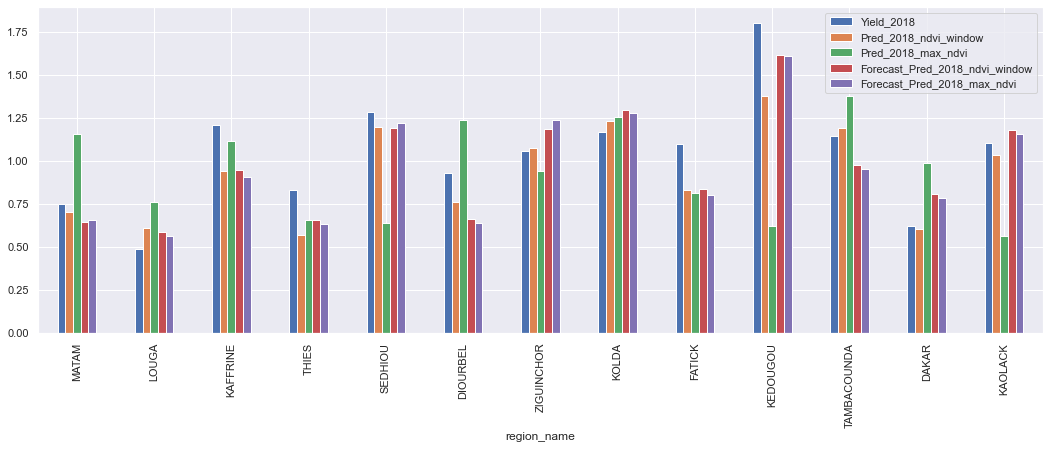

In [13]:
reg_yields_ndvi_window_2018.plot.bar(figsize=(18,6))

In [14]:
#pd.options.display.float_format = '{:,.2f}'.format
reg_yields_ndvi_window_2018 = reg_yields_ndvi_window_2018.round(2)
print(reg_yields_ndvi_window_2018)

             Yield_2018  Pred_2018_ndvi_window  Pred_2018_max_ndvi  \
region_name                                                          
MATAM              0.75                   0.70                1.16   
LOUGA              0.49                   0.61                0.76   
KAFFRINE           1.21                   0.94                1.12   
THIES              0.84                   0.57                0.66   
SEDHIOU            1.28                   1.20                0.64   
DIOURBEL           0.93                   0.76                1.24   
ZIGUINCHOR         1.06                   1.08                0.94   
KOLDA              1.17                   1.23                1.26   
FATICK             1.10                   0.83                0.82   
KEDOUGOU           1.81                   1.38                0.63   
TAMBACOUNDA        1.15                   1.20                1.38   
DAKAR              0.62                   0.61                0.99   
KAOLACK            1

In [15]:
reg_yields_ndvi_window_2018.reset_index(inplace=True)
print(reg_yields_ndvi_window_2018.columns)

Index(['region_name', 'Yield_2018', 'Pred_2018_ndvi_window',
       'Pred_2018_max_ndvi', 'Forecast_Pred_2018_ndvi_window',
       'Forecast_Pred_2018_max_ndvi'],
      dtype='object')


In [16]:
# Just rearrange the order of the columns
reg_yields_ndvi_window_2018 = reg_yields_ndvi_window_2018[['region_name', 'Yield_2018', 'Pred_2018_ndvi_window', 'Forecast_Pred_2018_ndvi_window', 'Pred_2018_max_ndvi', 'Forecast_Pred_2018_max_ndvi']]
print(reg_yields_ndvi_window_2018)

    region_name  Yield_2018  Pred_2018_ndvi_window  \
0         MATAM        0.75                   0.70   
1         LOUGA        0.49                   0.61   
2      KAFFRINE        1.21                   0.94   
3         THIES        0.84                   0.57   
4       SEDHIOU        1.28                   1.20   
5      DIOURBEL        0.93                   0.76   
6    ZIGUINCHOR        1.06                   1.08   
7         KOLDA        1.17                   1.23   
8        FATICK        1.10                   0.83   
9      KEDOUGOU        1.81                   1.38   
10  TAMBACOUNDA        1.15                   1.20   
11        DAKAR        0.62                   0.61   
12      KAOLACK        1.11                   1.04   

    Forecast_Pred_2018_ndvi_window  Pred_2018_max_ndvi  \
0                             0.65                1.16   
1                             0.59                0.76   
2                             0.95                1.12   
3          

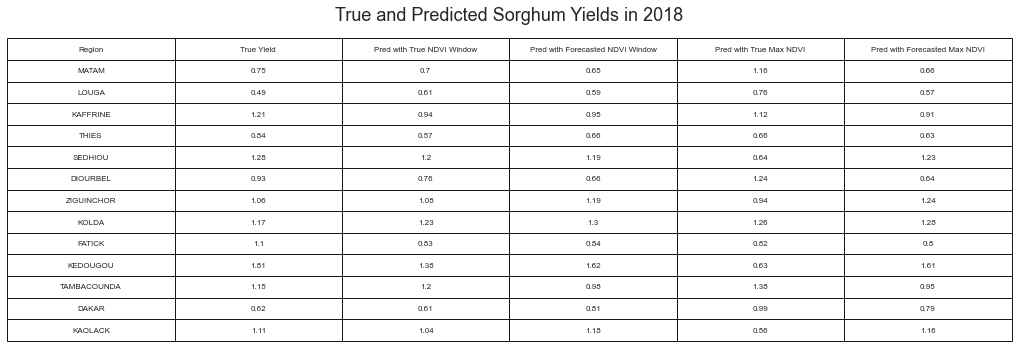

In [17]:
plt.figure()
cell_text = []
for row in range(len(reg_yields_ndvi_window_2018)):
    vals = reg_yields_ndvi_window_2018.iloc[row]
    cell_text.append(vals)
    
col_labels = ['Region', 'True Yield', 'Pred with True NDVI Window','Pred with Forecasted NDVI Window', 'Pred with True Max NDVI', 'Pred with Forecasted Max NDVI']
t = plt.table(cellText=cell_text, colLabels=col_labels, loc='center', cellLoc='center', fontsize = 36, colWidths=[0.5 for x in col_labels])
plt.axis('off')
t.scale(1, 1.8)
plt.title('True and Predicted Sorghum Yields in 2018', y=1.25, fontsize=18)

plt.savefig('timeseries_outputs/results_table.png',bbox_inches="tight", pad_inches=1, dpi=360)